# Assignment 5: Healthcare Claims Data Analysis Assignment

This notebook analyzes a sample of prospective claims data from Stony Brook University Hospital for May 2024.

**Files:**
- `STONYBRK_20240531_HEADER.csv`: one row per claim
- `STONYBRK_20240531_LINE.csv`: one row per service line
- `STONYBRK_20240531_CODE.csv`: one row per diagnosis code

I will:
- Explore claims, service lines, and diagnosis codes
- Analyze provider and payer patterns
- Identify common diagnoses and procedures
- Examine charges by payer and place of service

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
pd.set_option("display.max_columns", 60)

header_path = "STONYBRK_20240531_HEADER.csv"
line_path   = "STONYBRK_20240531_LINE.csv"
code_path   = "STONYBRK_20240531_CODE.csv"

df_header = pd.read_csv(header_path)
df_line   = pd.read_csv(line_path)
df_code   = pd.read_csv(code_path)

df_header.head()


,ClientId,ProspectiveClaimId,ClaimType,BillingProviderNPI,BillingProvFirstName,BillingProvLastName,AttendingProviderNPI,AttendingProvFirstName,AttendingProvLastName,RenderingProviderNPI,RenderingProvFirstName,RenderingProvLastName,ReferringProviderNPI,ReferringProvFirstName,ReferringProvLastName,OperatingProviderNPI,OperatingProvFirstName,OperatingProvLastName,ServiceFromDate,ServiceToDate,PrimaryPayerName,PrimaryPayerCode,PrimaryPayerCFI,SecondaryPayer,SecondaryPayerCode,SecondaryPayerCFI,TertianaryPayer,TertianaryPayerCode,TertianaryPayerCFI,DRG,AdmitType,DischargeStatus,AdmitDx,Facility_Location,CoderId,CoderName,PlaceOfService,WorkQueName,WorkQueId,ClinicalTrialIdentifier,PriorAuthorizationNo,InvestDeviceExmptNo,ReferralNo
0,49,35216986,P,1154376309,NEW YORK SPINE AND BRAIN SURGERY,NaN,NaN,NaN,NaN,1902082209,YUEHJIEN,GU,1.467416e+09,DAVID,FIORELLA -PHD,NaN,NaN,NaN,9/25/23 0:00,9/25/23 0:00,AETNA,147,AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INPATIENT,4,TESNJ,21,COMPLIANCE AUDIT,317,0,NaN,NaN,NaN
1,49,35235657,P,1154376309,NEW YORK SPINE AND BRAIN SURGERY,NaN,NaN,NaN,NaN,1902082209,YUEHJIEN,GU,1.467416e+09,DAVID,FIORELLA -PHD,NaN,NaN,NaN,9/27/23 0:00,9/27/23 0:00,AETNA,147,AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INPATIENT,4,TESNJ,21,COMPLIANCE AUDIT,317,0,NaN,NaN,NaN
2,49,35249003,P,1154376309,NEW YORK SPINE AND BRAIN SURGERY,NaN,NaN,NaN,NaN,1902082209,YUEHJIEN,GU,NaN,NaN,NaN,NaN,NaN,NaN,9/28/23 0:00,9/28/23 0:00,UNITED COMMUNITY PLAN GOVT PROGRAM,405,UA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INPATIENT,4,TESNJ,21,COMPLIANCE AUDIT,317,0,NaN,NaN,NaN
3,49,35249014,P,1154376309,NEW YORK SPINE AND BRAIN SURGERY,NaN,NaN,NaN,NaN,1902082209,YUEHJIEN,GU,NaN,NaN,NaN,NaN,NaN,NaN,9/29/23 0:00,9/29/23 0:00,MMIS,104,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INPATIENT,4,TESNJ,21,COMPLIANCE AUDIT,317,0,NaN,NaN,NaN
4,49,35249016,P,1154376309,NEW YORK SPINE AND BRAIN SURGERY,NaN,NaN,NaN,NaN,1902082209,YUEHJIEN,GU,NaN,NaN,NaN,NaN,NaN,NaN,9/28/23 0:00,9/28/23 0:00,EMPIRE BLUE HMO,94,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INPATIENT,4,TESNJ,21,COMPLIANCE AUDIT,317,0,NaN,NaN,NaN


In [15]:
for name, df in [("HEADER", df_header), ("LINE", df_line), ("CODE", df_code)]:
    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    print("\nInfo:")
    print(df.info())
    print("\nMissing values:\n", df.isna().sum())



===== HEADER =====
Shape: (388, 43)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ClientId                 388 non-null    int64  
 1   ProspectiveClaimId       388 non-null    int64  
 2   ClaimType                388 non-null    object 
 3   BillingProviderNPI       388 non-null    int64  
 4   BillingProvFirstName     388 non-null    object 
 5   BillingProvLastName      0 non-null      float64
 6   AttendingProviderNPI     2 non-null      float64
 7   AttendingProvFirstName   2 non-null      object 
 8   AttendingProvLastName    2 non-null      object 
 9   RenderingProviderNPI     388 non-null    int64  
 10  RenderingProvFirstName   388 non-null    object 
 11  RenderingProvLastName    388 non-null    object 
 12  ReferringProviderNPI     87 non-null     float64
 13  ReferringProvFirstName   87 non-null

In [17]:
# Convert service dates
df_header["ServiceFromDate"] = pd.to_datetime(df_header["ServiceFromDate"], errors="coerce")
df_header["ServiceToDate"]   = pd.to_datetime(df_header["ServiceToDate"], errors="coerce")

print("ServiceFromDate range:", df_header["ServiceFromDate"].min(), "to", df_header["ServiceFromDate"].max())

# Unique claims
n_unique_claims_header = df_header["ProspectiveClaimId"].nunique()
n_unique_claims_line   = df_line["ProspectiveClaimId"].nunique()
n_unique_claims_code   = df_code["ProspectiveClaimId"].nunique()

print("\nUnique claims (HEADER):", n_unique_claims_header)
print("Unique claims (LINE):  ", n_unique_claims_line)
print("Unique claims (CODE):  ", n_unique_claims_code)

# Average service lines per claim
lines_per_claim = df_line.groupby("ProspectiveClaimId")["LinePos"].count()
print("\nAverage service lines per claim:", lines_per_claim.mean())

# Average diagnosis codes per claim
dx_per_claim = df_code.groupby("ProspectiveClaimId")["CodePos"].count()
print("Average diagnosis codes per claim:", dx_per_claim.mean())


ServiceFromDate range: 2023-09-25 00:00:00 to 2024-05-29 00:00:00

Unique claims (HEADER): 388
Unique claims (LINE):   388
Unique claims (CODE):   388

Average service lines per claim: 1.3402061855670102
Average diagnosis codes per claim: 3.9587628865979383


## Part 1 – Data Loading and Exploration

From the metrics above:

- There are **388 unique claims** in the HEADER file.
- The `ServiceFromDate` ranges from **2023-09-25** to **2024-05-29**.
- The dataset averages about **1.34 service lines per claim**.
- There are about **3.96 diagnosis codes per claim** on average.

This suggests that each encounter typically has a small number of billed service lines but multiple diagnosis codes, consistent with moderately complex inpatient and outpatient encounters at an academic medical center.


## Part 2 – Relational Data Analysis

### Question 1: Provider Analysis

In [18]:
provider_claims = (
    df_header
    .groupby(["BillingProviderNPI", "BillingProvFirstName"])["ProspectiveClaimId"]
    .nunique()
    .reset_index(name="claim_count")
    .sort_values("claim_count", ascending=False)
)

top5_providers = provider_claims.head(5)
top5_providers


,BillingProviderNPI,BillingProvFirstName,claim_count
5,1821035601,SB INTERNISTS,152
0,1063468536,SB SURGICAL ASSOCIATES,81
2,1154376309,NEW YORK SPINE AND BRAIN SURGERY,69
4,1538114723,UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY,40
3,1437105905,SB PSYCHIATRIC ASSOCIATES,36


Question 1: Bar Chart

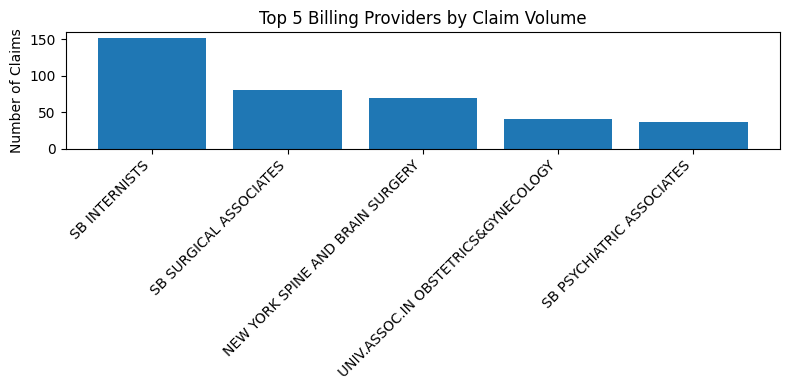

In [19]:
plt.figure(figsize=(8, 4))

labels = top5_providers["BillingProvFirstName"].astype(str)

plt.bar(labels, top5_providers["claim_count"])
plt.ylabel("Number of Claims")
plt.title("Top 5 Billing Providers by Claim Volume")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Question 1 – Provider Analysis

The top 5 billing providers by number of claims are:

1. **SB INTERNISTS** – 152 claims  
2. **SB SURGICAL ASSOCIATES** – 81 claims  
3. **NEW YORK SPINE AND BRAIN SURGERY** – 69 claims  
4. **UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY** – 40 claims  
5. **SB PSYCHIATRIC ASSOCIATES** – 36 claims  

SB INTERNISTS accounts for the largest share of claims, indicating a high volume of internal medicine or hospitalist encounters. The mix of surgical, OB/GYN, spine/brain surgery, and psychiatry groups reflects a broad clinical case-mix.


### Question 2: Payer Mix Analysis

In [20]:
payer_counts = (
    df_header["PrimaryPayerName"]
    .value_counts(dropna=False)
    .reset_index()
)
payer_counts.columns = ["PrimaryPayerName", "claim_count"]

payer_counts["percent"] = payer_counts["claim_count"] / payer_counts["claim_count"].sum() * 100

top5_payers = payer_counts.head(5)
top5_payers


,PrimaryPayerName,claim_count,percent
0,MEDICARE,242,62.371134
1,HEALTHFIRST FFS,46,11.855670
2,FIDELIS/BETTER HEALTH PLAN,26,6.701031
3,HIP MEDICAID,17,4.381443
4,HEALTHFIRST CAPITATED,10,2.577320


Question 2: Bar Chart

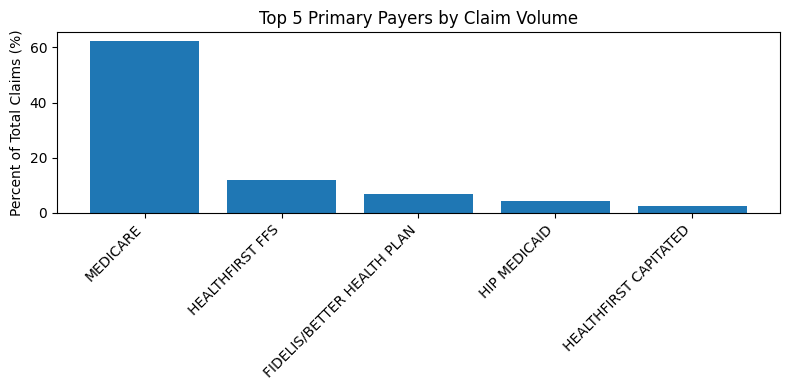

In [22]:
plt.figure(figsize=(8, 4))
plt.bar(top5_payers["PrimaryPayerName"], top5_payers["percent"])
plt.ylabel("Percent of Total Claims (%)")
plt.title("Top 5 Primary Payers by Claim Volume")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Question 2 – Payer Mix Analysis

Top 5 primary payers:

1. **MEDICARE** – 242 claims (~62.4% of all claims)  
2. **HEALTHFIRST FFS** – 46 claims (~11.9%)  
3. **FIDELIS/BETTER HEALTH PLAN** – 26 claims (~6.7%)  
4. **HIP MEDICAID** – 17 claims (~4.4%)  
5. **HEALTHFIRST CAPITATED** – 10 claims (~2.6%)

The payer mix is strongly dominated by Medicare, indicating an older or more medically complex population. Medicaid and managed-care payers contribute smaller but significant volumes.

### Question 3: Common Diagnoses

In [23]:
dx_counts = df_code["CodeValue"].value_counts().reset_index()
dx_counts.columns = ["ICD10_Code", "count"]
top10_dx = dx_counts.head(10)
top10_dx


,ICD10_Code,count
0,J96.01,62
1,I10,49
2,E78.5,49
3,G93.5,34
4,D64.9,29
5,I25.10,27
6,I61.9,26
7,I48.91,24
8,I60.8,24
9,I50.9,22


### Question 3 – Common Diagnoses

Top 10 ICD-10 diagnosis codes:

1. **J96.01** – 62  
2. **E78.5** – 49  
3. **I10** – 49  
4. **G93.5** – 34  
5. **D64.9** – 29  
6. **I25.10** – 27  
7. **I61.9** – 26  
8. **I48.91** – 24  
9. **I60.8** – 24  
10. **I50.9** – 22  

These codes reflect acute respiratory failure (J96.01), hyperlipidemia (E78.5), hypertension (I10), coronary artery disease, intracerebral hemorrhage, atrial fibrillation, and heart failure; consistent with a high-acuity neurology/cardiac inpatient population.


### Question 4: Common Procedures

In [24]:
proc_counts = df_line["HCPCS"].value_counts().reset_index()
proc_counts.columns = ["HCPCS", "count"]
top10_procs = proc_counts.head(10)
top10_procs


,HCPCS,count
0,99291,68
1,99233,48
2,99213,39
3,99223,33
4,99222,32
5,99232,21
6,90833,16
7,99204,14
8,99214,14
9,92557,14


Question 4: Bar Chart

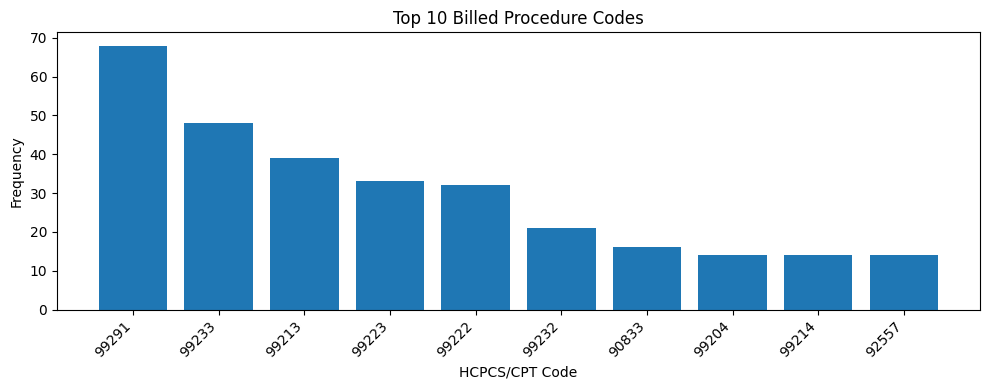

In [25]:
plt.figure(figsize=(10, 4))
plt.bar(top10_procs["HCPCS"].astype(str), top10_procs["count"])
plt.xlabel("HCPCS/CPT Code")
plt.ylabel("Frequency")
plt.title("Top 10 Billed Procedure Codes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Question 4 – Common Procedures

Top 10 HCPCS codes:

1. **99291** – 68  
2. **99233** – 48  
3. **99213** – 39  
4. **99223** – 33  
5. **99222** – 32  
6. **99232** – 21  
7. **90833** – 16  
8. **92557** – 14  
9. **99204** – 14  
10. **99214** – 14  

These are mostly critical care (99291) and inpatient/outpatient evaluation & management (99223, 99222, 99233, 99213, 99214), along with psychiatry and audiology services. This indicates high use of E/M billing codes across inpatient and clinic settings.


### Question 5: Service Location Analysis

In [27]:
df_header["PlaceOfService"].value_counts(dropna=False)

pos_map = {
    21: "INPATIENT",
    11: "DOCTOR'S OFFICE",
    22: "OUTPATIENT HOSPITAL",
    23: "EMERGENCY ROOM"
}

df_header["POS_group"] = df_header["PlaceOfService"].map(pos_map).fillna("OTHER")

pos_group_counts = df_header["POS_group"].value_counts().reset_index()
pos_group_counts.columns = ["POS_group", "claim_count"]
pos_group_counts["percent"] = pos_group_counts["claim_count"] / pos_group_counts["claim_count"].sum() * 100
pos_group_counts



,POS_group,claim_count,percent
0,INPATIENT,231,59.536082
1,DOCTOR'S OFFICE,132,34.020619
2,OUTPATIENT HOSPITAL,24,6.185567
3,EMERGENCY ROOM,1,0.257732


### Question 5 – Service Location Analysis

Using CPT POS codes:

- **INPATIENT (21):** 231 claims (~59.5%)  
- **DOCTOR'S OFFICE (11):** 132 claims (~34.0%)  
- **OUTPATIENT HOSPITAL (22):** 24 claims (~6.2%)  
- **EMERGENCY ROOM (23):** 1 claim (~0.3%)  

Most claims occur in **inpatient** and **office** settings. This aligns with a hospital-based practice plus outpatient clinics; ED and outpatient hospital claims are present but smaller in volume.


## Part 3: Advanced Analysis with Joins

### Question 6: Claims with High Service Line Counts



In [29]:
# Number of lines per claim
lines_per_claim = df_line.groupby("ProspectiveClaimId")["LinePos"].count()

# Total charges per claim
charges_per_claim = df_line.groupby("ProspectiveClaimId")["Charges"].sum()

df_header_lines = df_header.copy()
df_header_lines["line_count"] = df_header_lines["ProspectiveClaimId"].map(lines_per_claim)
df_header_lines["total_charges"] = df_header_lines["ProspectiveClaimId"].map(charges_per_claim)

df_header_lines["line_count"].describe()

high_line_claims = df_header_lines[df_header_lines["line_count"] >= 5]

high_line_claims[[
    "ProspectiveClaimId",
    "BillingProviderNPI",
    "BillingProvFirstName",
    "line_count",
    "total_charges"
]].sort_values("line_count", ascending=False)


,ProspectiveClaimId,BillingProviderNPI,BillingProvFirstName,line_count,total_charges
333,36794825,1083660575,SB CHILDREN'S SERVICE,7,1163
138,36668119,1538114723,UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY,6,1030
122,36740402,1538114723,UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY,6,945
23,36710175,1538114723,UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY,5,873
217,36757684,1538114723,UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY,5,873


### Question 6 – Claims with High Service Line Counts

There are **5 claims** with **5 or more service lines**. Examples:

- Claim **36794825** – SB CHILDREN'S SERVICE, 7 lines, total charges ≈ \$1,163  
- Claims **36740402**, **36668119**, **36710175**, **36757684** – UNIV.ASSOC.IN OBSTETRICS&GYNECOLOGY, 5–6 lines and charges in the \$873–\$1,030 range  

These high-line claims likely represent more complex encounters with multiple procedures or bundled services, which revenue cycle teams may want to monitor for coding and reimbursement accuracy.


### Question 7: Diagnosis-Procedure Combinations



In [30]:
# Filter service lines for CPT 99291
df_99291_lines = df_line[df_line["HCPCS"] == "99291"].copy()
claims_99291 = df_99291_lines["ProspectiveClaimId"].unique()

# Diagnoses for those claims
df_99291_dx = df_code[df_code["ProspectiveClaimId"].isin(claims_99291)].copy()

dx_counts_99291 = df_99291_dx["CodeValue"].value_counts().reset_index()
dx_counts_99291.columns = ["ICD10_Code", "count"]
dx_counts_99291.head(10)


,ICD10_Code,count
0,J96.01,53
1,G93.5,34
2,E78.5,33
3,I61.9,26
4,D64.9,25
5,I60.8,24
6,I10,24
7,I95.9,20
8,D72.829,19
9,I67.848,17


### Question 7 – Diagnosis–Procedure Combinations for CPT 99291

For claims with **CPT 99291 (critical care)**:

- The most common associated diagnosis is **J96.01** (acute respiratory failure with hypoxia) with **53 occurrences**.
- Other frequent diagnoses include:
  - **G93.5** (compression of brain)
  - **E78.5** (hyperlipidemia)
  - **I61.9** (intracerebral hemorrhage)
  - **D64.9** (anemia, unspecified)
  - **I60.8** (other subarachnoid hemorrhage)
  - **I10** (hypertension)

This pattern shows that critical care billing is associated with severe neurologic and cardiorespiratory conditions, which is what we expect in ICU-level care.


### Question 8: Charges by Payer

In [31]:
payer_charges = (
    df_header_lines
    .groupby("PrimaryPayerName")
    .agg(
        total_charges=("total_charges", "sum"),
        avg_charges_per_claim=("total_charges", "mean"),
        n_claims=("ProspectiveClaimId", "nunique")
    )
    .reset_index()
    .sort_values("total_charges", ascending=False)
)

payer_charges.head(10)


,PrimaryPayerName,total_charges,avg_charges_per_claim,n_claims
17,MEDICARE,131008,541.355372,242
12,HEALTHFIRST FFS,29794,647.695652,46
9,FIDELIS/BETTER HEALTH PLAN,10810,415.769231,26
14,HIP MEDICAID,10014,589.058824,17
0,AETNA,6930,1155.000000,6
4,DIRECT SELF PAY,6575,1095.833333,6
21,UNITED COMMUNITY PLAN GOVT PROGRAM,5175,1035.000000,5
10,HEALTHFIRST CAPITATED,4905,490.500000,10
7,EMPIRE BLUE SR,4620,1155.000000,4
15,MAGNACARE,3465,1155.000000,3


### Question 8 – Charges by Payer

Top 5 payers by **total charges**:

1. **MEDICARE** – total ≈ \$131,008; avg ≈ \$541/claim; 242 claims  
2. **HEALTHFIRST FFS** – total ≈ \$29,794; avg ≈ \$648/claim; 46 claims  
3. **FIDELIS/BETTER HEALTH PLAN** – total ≈ \$10,810; avg ≈ \$416/claim; 26 claims  
4. **HIP MEDICAID** – total ≈ \$10,014; avg ≈ \$589/claim; 17 claims  
5. **AETNA** – total ≈ \$6,930; avg ≈ \$1,155/claim; 6 claims  

Medicare drives the largest total charge volume due to high claim count. Some commercial payers (e.g., Aetna, Empire Blue) show higher **average charges per claim**, which may reflect more complex or higher-paying encounters per patient.


## Part 4: Creative Analysis
### Question 9: Your Own Analysis Develop and answer your own analytical question using the claims data.

**My question:** How do average total charges per claim vary by place of service?

In [33]:
pos_charge_stats = (
    df_header_lines
    .groupby("POS_group")
    .agg(
        avg_charges=("total_charges", "mean"),
        median_charges=("total_charges", "median"),
        n_claims=("ProspectiveClaimId", "nunique")
    )
    .reset_index()
)

pos_charge_stats

# This uses a merge of HEADER + LINE (already in df_header_lines) and groupby on POS_group.


,POS_group,avg_charges,median_charges,n_claims
0,DOCTOR'S OFFICE,423.901515,430.0,132
1,EMERGENCY ROOM,410.000000,410.0,1
2,INPATIENT,678.593074,525.0,231
3,OUTPATIENT HOSPITAL,989.625000,430.0,24


Question 9: Bar Chart

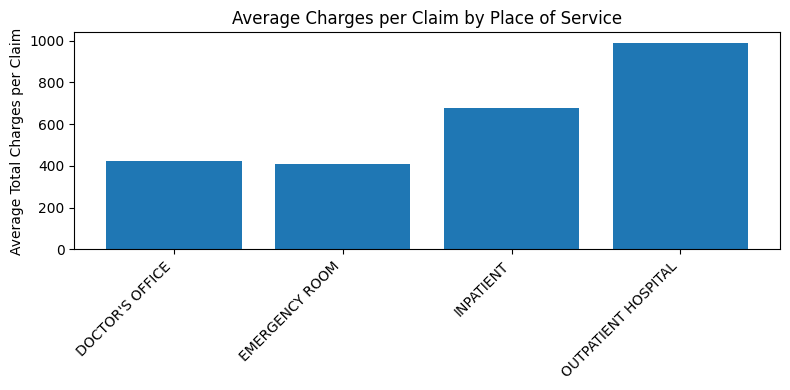

In [34]:
plt.figure(figsize=(8, 4))
plt.bar(pos_charge_stats["POS_group"], pos_charge_stats["avg_charges"])
plt.ylabel("Average Total Charges per Claim")
plt.title("Average Charges per Claim by Place of Service")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Question 9 – Relationship Between Place of Service and Average Charges

Average total charges per claim by POS group:

- **OUTPATIENT HOSPITAL:** ~\$989.63 (24 claims)  
- **INPATIENT:** ~\$678.59 (231 claims)  
- **DOCTOR'S OFFICE:** ~\$423.90 (132 claims)  
- **EMERGENCY ROOM:** ~\$410.00 (1 claim, very small sample)

Outpatient hospital encounters have the highest **average** charges per claim, likely representing procedure-heavy or short-stay visits. Inpatient encounters also have high average charges, reflecting complex hospitalizations. Office and ED visits are lower-cost on average, consistent with typical reimbursement patterns.
